In [1]:
import pandas as pd
import pymorphy2 as pm
import gensim
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import itertools
import operator
import string
import seaborn as sns
import functions
from functions import average, save_vars, load_vars
from gensim.models import KeyedVectors
from pprint import pprint
import functions
from IPython.core.display import display, HTML

In [2]:
model = KeyedVectors.load_word2vec_format('/media/anon/9CA43AAEA43A8AB2/word2vec_models/ruwikiruscorpora_upos_cbow_300_20_2017.bin', binary=True)

In [10]:
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
morph = pm.MorphAnalyzer()
PATH = 'data/songs/'
words_to_remove = [u'куплет', u'припев', u'автор', u'текста', u'текст', u'композитор', u'музыка', u'аутро']
min_words = 40
min_songs = 5

Pretty printing has been turned OFF


In [36]:
def read_file(path):
    try:
        f = io.open(path, 'r', encoding='cp1251')
        return f.read()  # utf-8 expected
    
    except:
        f = io.open(path, 'r')
        return f.read()


def parse_text(string_raw):
    lines = string_raw.split('\n')  # convert string to list
    lines = [i for i in lines if i]  # remove empty lines
    lines = [i.replace('&quot;', '') for i in lines]  # remove &quot;
    lines = [i.replace(u'ё', u'е') for i in lines]  # convert ё to е
    lines_cleared = [''.join([symbol for symbol in word if symbol not in string.punctuation]) for word in lines]  # remove punctuation
    words = [i.split(' ') for i in lines_cleared]  # 2d-list
    words = list(itertools.chain.from_iterable(words))  # flatten 2D list
    words = [word.lower() for word in words if len(word) >= 3 and word.lower() not in words_to_remove]  # cut short words
    return words
    
    
def check_in_model(word):
    if word + '_ADJ' in model:
        return word + '_ADJ'
    if word + '_VERB' in model:
        return word + '_VERB'
    if word + '_NOUN' in model:
        return word + '_NOUN'

    return None

            
def parse_words(words):
    words_recognized = list()
    for word in words:
        word_normal = morph.parse(word)[0].normal_form
        word_recognized = check_in_model(word_normal)
        if word_recognized and word_recognized not in words_recognized:  # pass non-unique recognized words
            words_recognized.append(word_recognized)
        
    return words_recognized

In [30]:
vectors_data = dict()
for singer in sorted([i.decode('utf-8') for i in os.listdir(PATH)]):
    vectors_data[singer] = dict()
    for song in sorted(os.listdir(PATH + singer)):
        vectors_data[singer][song] = dict()
        vectors_data[singer][song]['words'] = list()
        string_raw = read_file(PATH + singer + '/' + song)
        words = parse_text(string_raw)
        vectors_data[singer][song]['words'] = parse_words(words)

save_vars(variable=vectors_data, filename='vectors_data_noun_verb_adj_%s.pickle' % min_words)

In [71]:
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s.pickle' % min_words)
words_count = 1000
for singer in vectors_data.keys():
    for song in vectors_data[singer].keys():
        vectors_data[singer][song]['words_count'] = len(vectors_data[singer][song]['words'])
        if vectors_data[singer][song]['words_count'] < min_words:
            del vectors_data[singer][song]
        
    if len(vectors_data[singer]) < min_songs:
        print '%s has < 5 songs (%s songs), removing' % (singer, len(vectors_data[singer]))
        del vectors_data[singer]

for singer in vectors_data:
    for song in vectors_data[singer]:
        vectors_data[singer][song]['words_count'] = len(vectors_data[singer][song]['words'])
        if 'similarities' not in  vectors_data[singer][song]:
            vectors_data[singer][song]['similarities'] = dict()
        if 'average_similarity' not in  vectors_data[singer][song]:
            vectors_data[singer][song]['average_similarity'] = dict()
            
        combinations = itertools.combinations(vectors_data[singer][song]['words'][:words_count], 2)
        combinations = parse_combinations(combinations)
        vectors_data[singer][song]['similarities'][words_count] = [model.similarity(i[0], i[1]) for i in combinations]
        vectors_data[singer][song]['average_similarity'][words_count] = average(vectors_data[singer][song]['similarities'][words_count])
        
save_vars(variable=vectors_data, filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))

Надежда Бабкина has < 5 songs (1 songs), removing
Чай вдвоем has < 5 songs (3 songs), removing
Ленинград has < 5 songs (3 songs), removing


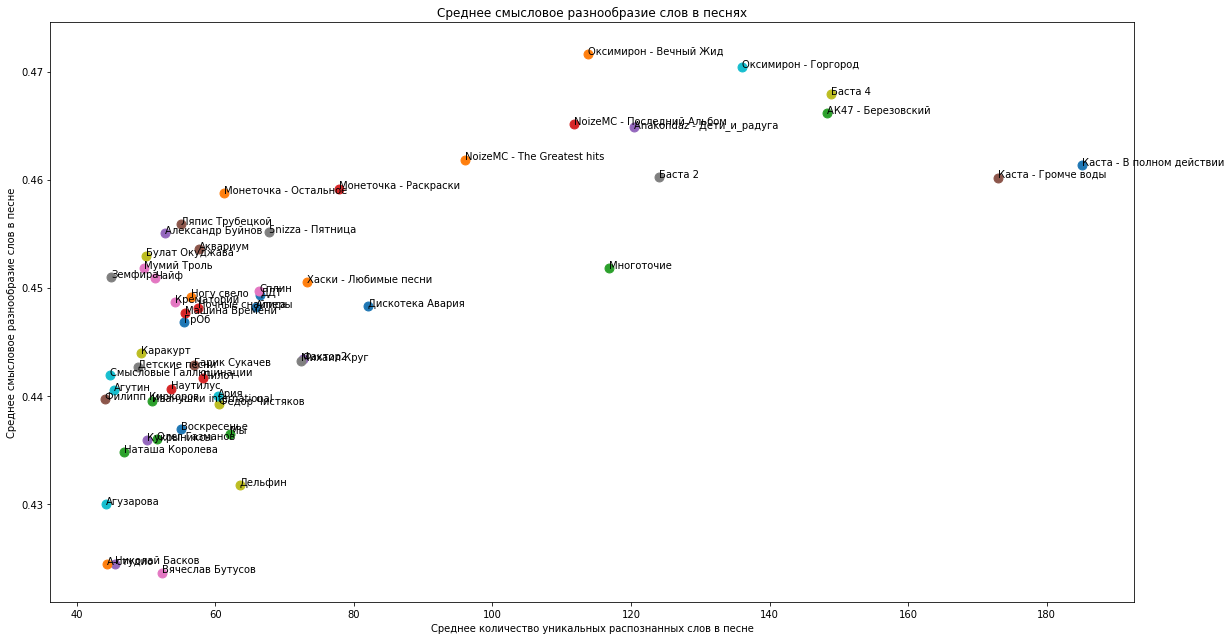

In [72]:
words_count = 1000
min_words = 40
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))
fig = plt.figure(figsize=[16, 9])
results = dict()
for singer in vectors_data:
    results[singer] = dict()
    results[singer]['words_count'] = average([song['words_count'] for song in vectors_data[singer].values()])
    results[singer]['average_diversity'] = average([-0.5 * song['average_similarity'][words_count] + 0.5
                                                    for song in vectors_data[singer].values()
                                                    if song['average_similarity'][words_count]])

    plt.scatter(results[singer]['words_count'],
                results[singer]['average_diversity'],
                s=80, label=singer)

    plt.annotate(singer,
                 (results[singer]['words_count'],
                  results[singer]['average_diversity']), size=10)

plt.xlabel(u'Среднее количество уникальных распознанных слов в песне')
plt.ylabel(u'Среднее смысловое разнообразие слов в песне')
plt.title(u'Среднее смысловое разнообразие слов в песнях')
plt.tight_layout()
plt.savefig('scatter_model_w2v_05gb_noun_verb_adj_%s.png' % min_words)
csv_data = pd.DataFrame.from_dict(results)
csv_data = csv_data.transpose()
csv_data.to_csv('results_w2v_05gb_noun_verb_adj_%s.csv' % min_words, encoding = 'utf8')

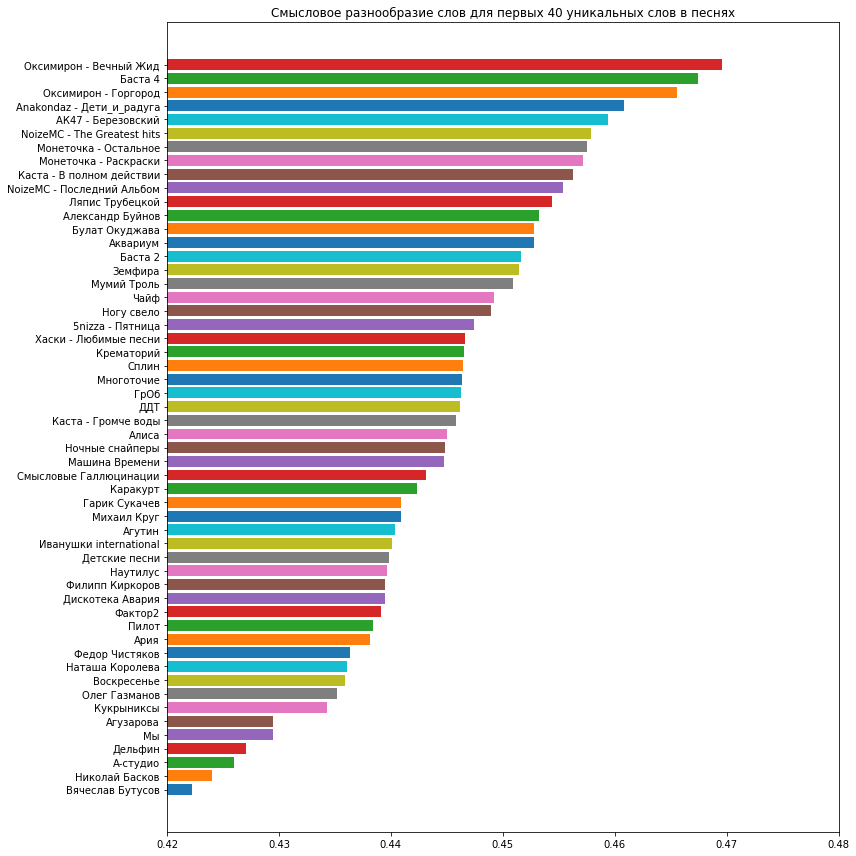

In [73]:
words_count = 40
min_words = 40
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))
fig = plt.figure(figsize=[12, 12])
plot_data = list()
for singer in vectors_data:
    plot_data.append([singer, average([-0.5 * song['average_similarity'][words_count] + 0.5
                                       for song in vectors_data[singer].values()
                                       if song['average_similarity'][words_count] is not None])])

plot_data.sort(key=operator.itemgetter(1))

for bar in plot_data:
    plt.barh(bar[0], bar[1])

plt.title(u'Смысловое разнообразие слов для первых %s уникальных слов в песнях' % words_count)
plt.xlim([0.42, 0.48])
plt.tight_layout()
plt.savefig('barh_%s.png' % words_count)

In [75]:
words_count = 1000
min_words = 40
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))
csv_data = list()
for singer in vectors_data:
    for song in vectors_data[singer]:
        csv_data.append([singer, song, vectors_data[singer][song]['average_similarity'][words_count],
                         vectors_data[singer][song]['words_count']])

csv_data = pd.DataFrame(csv_data)
csv_data.to_csv('data_by_song.csv', encoding = 'utf-8')

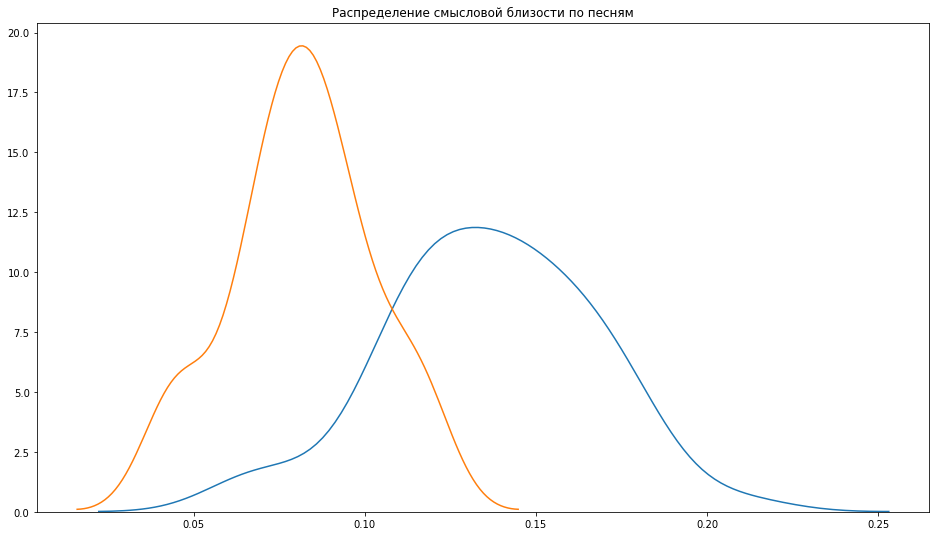

In [76]:
words_count = 1000
min_words = 40
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))
plt.figure(figsize=(16, 9))
for singer in [u'Дельфин', u'Монеточка - Раскраски']:
    sns.kdeplot([song['average_similarity'][words_count] for song in vectors_data[singer].values()])
    plt.title(u'Распределение смысловой близости по песням')

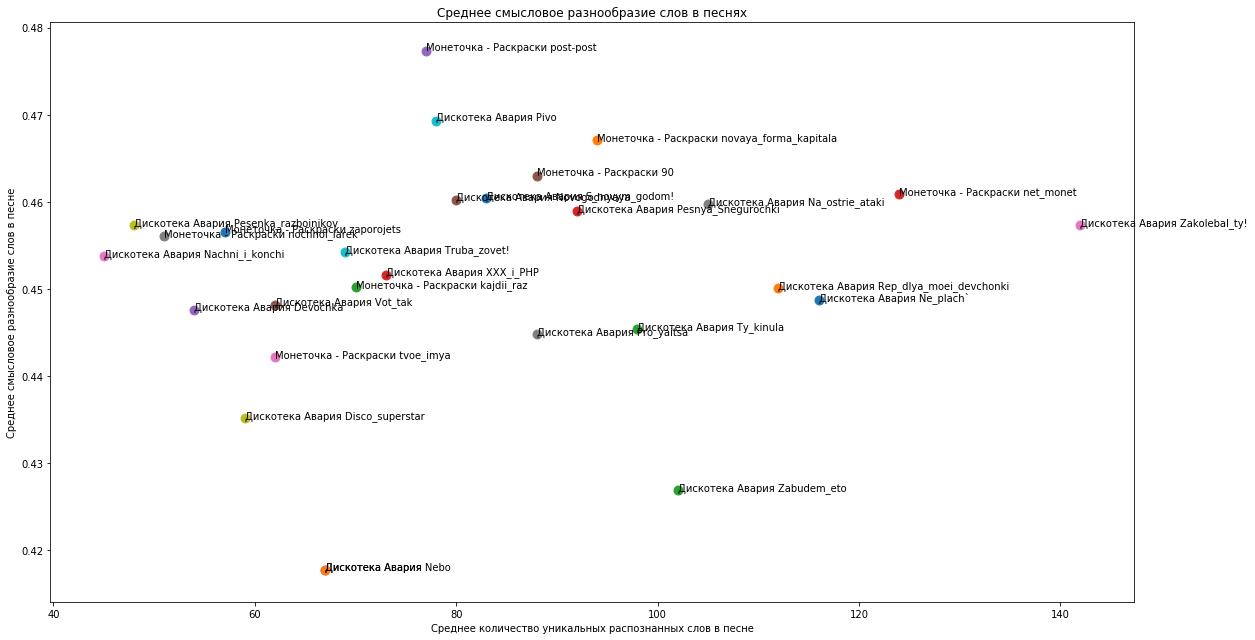

In [79]:
words_count = 1000
min_words = 40
vectors_data = load_vars(filename='vectors_data_noun_verb_adj_%s_%s_parsed.pickle' % (min_words, words_count))
singers = [u'Монеточка - Раскраски', u'Дискотека Авария']
fig = plt.figure(figsize=[16, 9])
words_count = 1000
if words_count == 1000:  # scatter chart should be used only with words_count=1000
    results = dict()
    for singer in singers:
        results[singer] = dict()
        for song in vectors_data[singer]:
            results[singer][song] = dict()
            results[singer][song]['words_count'] = vectors_data[singer][song]['words_count']
            results[singer][song]['average_diversity'] = -0.5 * vectors_data[singer][song]['average_similarity'][words_count] + 0.5

            plt.scatter(results[singer][song]['words_count'],
                        results[singer][song]['average_diversity'],
                        s=80, label=singer)

            plt.annotate(singer + ' ' + song[:-4],
                         (results[singer][song]['words_count'],
                          results[singer][song]['average_diversity']), size=10)
            
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(u'Среднее количество уникальных распознанных слов в песне')
    plt.ylabel(u'Среднее смысловое разнообразие слов в песне')
    plt.title(u'Среднее смысловое разнообразие слов в песнях')
    plt.tight_layout()